### Thinkful Data Science Unit 3.1.4 - Model Comparison
#### Prepared by Robin Fladebo

#### Assignment

Find a data set and build a KNN Regression and an OLS regression. Compare the two. How similar are they? Do they miss in different ways?

Create a Jupyter notebook with your models. At the end in a markdown cell write a few paragraphs to describe the models' behaviors and why you favor one model or the other. Try to determine whether there is a situation where you would change your mind, or whether one is unambiguously better than the other. Lastly, try to note what it is about the data that causes the better model to outperform the weaker model.

In [182]:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.5f}'.format

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import neighbors
from sklearn.model_selection import cross_val_score

Source of dataset: Kaggle "Diamonds" https://www.kaggle.com/shivam2503/diamonds

In [2]:
diamonds = pd.read_csv('../../Datafiles/unit_3/diamonds.csv')

In [3]:
diamonds.head(7)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23000,Ideal,E,SI2,61.50000,55.00000,326,3.95000,3.98000,2.43000
1,2,0.21000,Premium,E,SI1,59.80000,61.00000,326,3.89000,3.84000,2.31000
2,3,0.23000,Good,E,VS1,56.90000,65.00000,327,4.05000,4.07000,2.31000
3,4,0.29000,Premium,I,VS2,62.40000,58.00000,334,4.20000,4.23000,2.63000
4,5,0.31000,Good,J,SI2,63.30000,58.00000,335,4.34000,4.35000,2.75000
5,6,0.24000,Very Good,J,VVS2,62.80000,57.00000,336,3.94000,3.96000,2.48000
6,7,0.24000,Very Good,I,VVS1,62.30000,57.00000,336,3.95000,3.98000,2.47000


*Column definitions, from Kaggle*

price price in US dollars (\$326--\$18,823)

carat weight of the diamond (0.2--5.01)

cut quality of the cut (Fair, Good, Very Good, Premium, Ideal)

color diamond colour, from J (worst) to D (best)

clarity a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

x length in mm (0--10.74)

y width in mm (0--58.9)

z depth in mm (0--31.8)

depth total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

table width of top of diamond relative to widest point (43--95)

Notes:

--Depth percentage is a measure of 'brilliance' and is related to the type of cut (not quality of cut). Generally, higher depth values result in lower sparkle and thus are less attractive.

--Table width is important for light refraction and is another of the sevearl factors that relate to brilliance. A table that is too large limits the size of the bezel area, which is where the most light is refracted.

#### Data cleaning and exploration

In [4]:
#Drop the column Unnamed; it has no use
diamonds = diamonds.drop(columns = 'Unnamed: 0', axis = 1)

In [5]:
diamonds.shape

(53940, 10)

In [6]:
#Use 'info' as an alternative to diamonds.dtypes that gives more information (shows non-null count and memory use)
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
carat      53940 non-null float64
cut        53940 non-null object
color      53940 non-null object
clarity    53940 non-null object
depth      53940 non-null float64
table      53940 non-null float64
price      53940 non-null int64
x          53940 non-null float64
y          53940 non-null float64
z          53940 non-null float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [7]:
#Rename some columns for clarity
diamonds = diamonds.rename(columns = {'x':'length_mm', 'y':'width_mm', 'z':'depth_mm', 'depth':'depth_pcnt'})

In [8]:
#Confirming there are no null values present
diamonds.isnull().values.any()

False

In [9]:
#Explore the numeric fields; do reasonableness check
diamonds.describe()

,carat,depth_pcnt,table,price,length_mm,width_mm,depth_mm
count,53940.00000,53940.00000,53940.00000,53940.00000,53940.00000,53940.00000,53940.00000
mean,0.79794,61.74940,57.45718,3932.79972,5.73116,5.73453,3.53873
std,0.47401,1.43262,2.23449,3989.43974,1.12176,1.14213,0.70570
min,0.20000,43.00000,43.00000,326.00000,0.00000,0.00000,0.00000
25%,0.40000,61.00000,56.00000,950.00000,4.71000,4.72000,2.91000
50%,0.70000,61.80000,57.00000,2401.00000,5.70000,5.71000,3.53000
75%,1.04000,62.50000,59.00000,5324.25000,6.54000,6.54000,4.04000
max,5.01000,79.00000,95.00000,18823.00000,10.74000,58.90000,31.80000


Zero length, width or depth is not a reasonable value. What do those records look like? 

In [10]:
diamonds.loc[(diamonds['width_mm'] == 0) | (diamonds['width_mm'] == 0) | (diamonds['depth_mm'] == 0)].head(10)

,carat,cut,color,clarity,depth_pcnt,table,price,length_mm,width_mm,depth_mm
2207,1.00000,Premium,G,SI2,59.10000,59.00000,3142,6.55000,6.48000,0.00000
2314,1.01000,Premium,H,I1,58.10000,59.00000,3167,6.66000,6.60000,0.00000
4791,1.10000,Premium,G,SI2,63.00000,59.00000,3696,6.50000,6.47000,0.00000
5471,1.01000,Premium,F,SI2,59.20000,58.00000,3837,6.50000,6.47000,0.00000
10167,1.50000,Good,G,I1,64.00000,61.00000,4731,7.15000,7.04000,0.00000
11182,1.07000,Ideal,F,SI2,61.60000,56.00000,4954,0.00000,6.62000,0.00000
11963,1.00000,Very Good,H,VS2,63.30000,53.00000,5139,0.00000,0.00000,0.00000
13601,1.15000,Ideal,G,VS2,59.20000,56.00000,5564,6.88000,6.83000,0.00000
15951,1.14000,Fair,G,VS1,57.50000,67.00000,6381,0.00000,0.00000,0.00000
24394,2.18000,Premium,H,SI2,59.40000,61.00000,12631,8.49000,8.45000,0.00000


Though other values look okay, drop the records with zero length, width or depth and non-zero values for table or depth percentage, of which x, y, z are factors. My assumption is that the zero values represent missing values

In [11]:
diamonds = diamonds[(diamonds[['width_mm', 'length_mm', 'depth_mm']] != 0).all(axis=1)]

In [12]:
# 20 records were dropped
diamonds.shape

(53920, 10)

Width, length and depth in mm can be combined into a single variable representing the size/volume of the diamond.

In [13]:
diamonds['vol_mm'] = diamonds.width_mm * diamonds.length_mm * diamonds.depth_mm
diamonds = diamonds.drop(columns = {'width_mm', 'length_mm', 'depth_mm'}, axis = 1)

In [14]:
diamonds.head()

,carat,cut,color,clarity,depth_pcnt,table,price,vol_mm
0,0.23000,Ideal,E,SI2,61.50000,55.00000,326,38.20203
1,0.21000,Premium,E,SI1,59.80000,61.00000,326,34.50586
2,0.23000,Good,E,VS1,56.90000,65.00000,327,38.07688
3,0.29000,Premium,I,VS2,62.40000,58.00000,334,46.72458
4,0.31000,Good,J,SI2,63.30000,58.00000,335,51.91725


In [15]:
diamonds.tail()

,carat,cut,color,clarity,depth_pcnt,table,price,vol_mm
53935,0.72000,Ideal,D,SI1,60.80000,57.00000,2757,115.92000
53936,0.72000,Good,D,SI1,63.10000,55.00000,2757,118.11017
53937,0.70000,Very Good,D,SI1,62.80000,60.00000,2757,114.44973
53938,0.86000,Premium,H,SI2,61.00000,58.00000,2757,140.76612
53939,0.75000,Ideal,D,SI2,62.20000,55.00000,2757,124.56844


#### Visualization

Carat weight is highly correlated to price, as is the volume (size) of the diamond. Volume and carat weight are very closely related (they provide basically the same information). Table is negatively correlated to price; this makes sense, because larger table limits bezels which affects brilliance.

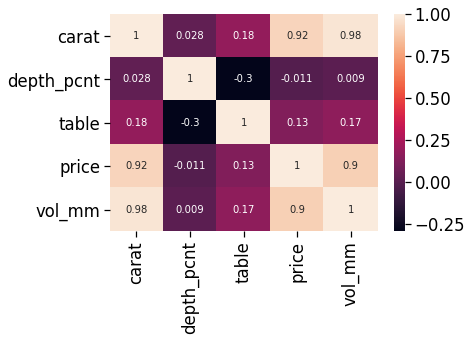

In [16]:
#Correlation between variables
diamonds_corr = diamonds.corr()
sns.heatmap(data=diamonds_corr, annot=True)

In [17]:
diamonds['cut'].value_counts()

Ideal        21548
Premium      13780
Very Good    12081
Good          4902
Fair          1609
Name: cut, dtype: int64

 (0, 25000),

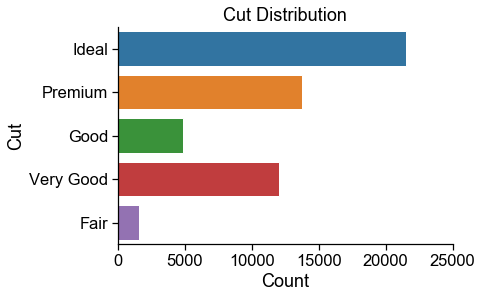

In [18]:
fig, ax = plt.subplots()
sns.set_style('whitegrid')
sns.color_palette('Paired', 10)
sns.despine()
sns.countplot(data=diamonds, y = 'cut', orient = 'h', ax=ax)
ax.set(ylabel="Cut", xlabel = "Count", xlim = (0, 25000),
title="Cut Distribution")

In [19]:
diamonds['color'].value_counts()

G    11284
E     9797
F     9538
H     8298
D     6774
I     5421
J     2808
Name: color, dtype: int64

 (0, 15000),

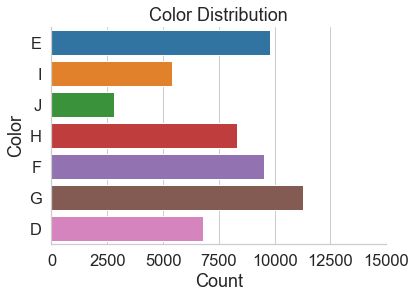

In [20]:
fig, ax = plt.subplots()
sns.set_style('whitegrid')
sns.color_palette('Paired', 10)
sns.despine()
sns.countplot(data=diamonds, y = 'color', orient = 'h', ax=ax)
ax.set(ylabel="Color", xlabel = "Count", xlim = (0, 15000),
title="Color Distribution")

In [21]:
diamonds['clarity'].value_counts()

SI1     13063
VS2     12254
SI2      9185
VS1      8170
VVS2     5066
VVS1     3654
IF       1790
I1        738
Name: clarity, dtype: int64

 (0, 15000),

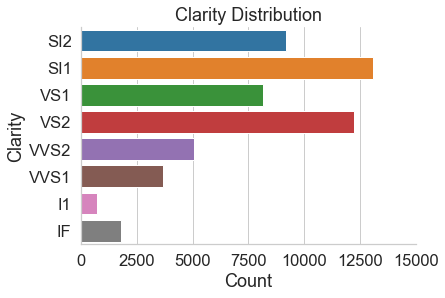

In [22]:
fig, ax = plt.subplots()
sns.set_style('whitegrid')
sns.color_palette('Paired', 10)
sns.despine()
sns.countplot(data=diamonds, y = 'clarity', orient = 'h', ax=ax)
ax.set(ylabel="Clarity", xlabel = "Count", xlim = (0, 15000),
title="Clarity Distribution")

#### Examine the relationship between carat weight and price

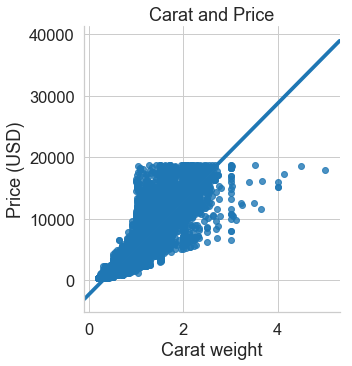

In [23]:
sns.set_style('whitegrid')
cwp = sns.lmplot(x = 'carat', y = 'price', data = diamonds)
cwp = (cwp.set_axis_labels("Carat weight", "Price (USD)"))
ax = plt.gca()
ax.set_title("Carat and Price")

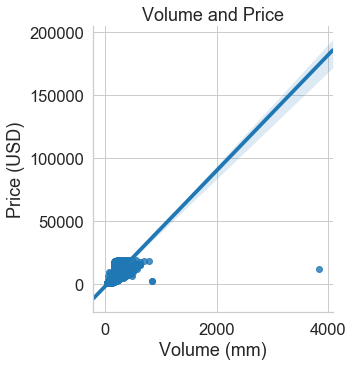

In [24]:
sns.set_style('whitegrid')
vp = sns.lmplot(x = 'vol_mm', y = 'price', data = diamonds)
vp = (vp.set_axis_labels("Volume (mm)", "Price (USD)"))
ax = plt.gca()
ax.set_title("Volume and Price")

One-hot encode the categorical features (color, cut and clarity)

In [143]:
diamonds_encoded = pd.get_dummies(data=diamonds)

In [144]:
diamonds_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53920 entries, 0 to 53939
Data columns (total 25 columns):
carat            53920 non-null float64
depth_pcnt       53920 non-null float64
table            53920 non-null float64
price            53920 non-null int64
vol_mm           53920 non-null float64
cut_Fair         53920 non-null uint8
cut_Good         53920 non-null uint8
cut_Ideal        53920 non-null uint8
cut_Premium      53920 non-null uint8
cut_Very Good    53920 non-null uint8
color_D          53920 non-null uint8
color_E          53920 non-null uint8
color_F          53920 non-null uint8
color_G          53920 non-null uint8
color_H          53920 non-null uint8
color_I          53920 non-null uint8
color_J          53920 non-null uint8
clarity_I1       53920 non-null uint8
clarity_IF       53920 non-null uint8
clarity_SI1      53920 non-null uint8
clarity_SI2      53920 non-null uint8
clarity_VS1      53920 non-null uint8
clarity_VS2      53920 non-null uint8
clarity_V

In [145]:
diamonds_features = diamonds_encoded.drop(columns = 'price', axis = 1 )
diamonds_target = diamonds['price']

In [146]:
X = diamonds_features
y = diamonds_target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 8)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(43136, 24) (43136,)
(10784, 24) (10784,)


#### Scale the numeric variables. It is best to scale after the test-train split. (Reference: ... )

In [147]:
scaler = StandardScaler()

#Improvement: Loop over the data frame columns and populate a numeric columns list by testing the data type
num_cols = ['carat', 'depth_pcnt', 'table', 'vol_mm']

X_train_num = pd.DataFrame(scaler.fit_transform(X_train[num_cols]), index = X_train.index)
X_test_num = pd.DataFrame(scaler.fit_transform(X_test[num_cols]), index = X_test.index)

In [148]:
#Why does a merge on indexes result in column names in tuple format which I cannot subsequently rename?
#Why didn't the suffixes argument of the merge function work when I coded it?
X_train = pd.concat([X_train, X_train_num], axis = 1)
X_test = pd.concat([X_test, X_test_num], axis = 1)

In [149]:
X_train.rename(columns={0:'carat_sc', 1:'depth_pcnt_sc', 2: 'table_sc', 3: 'vol_mm_sc'}, inplace=True)
X_test.rename(columns={0:'carat_sc', 1:'depth_pcnt_sc', 2: 'table_sc', 3: 'vol_mm_sc'}, inplace=True)

In [150]:
X_train.drop(columns = num_cols, inplace=True)
X_test.drop(columns = num_cols, inplace=True)

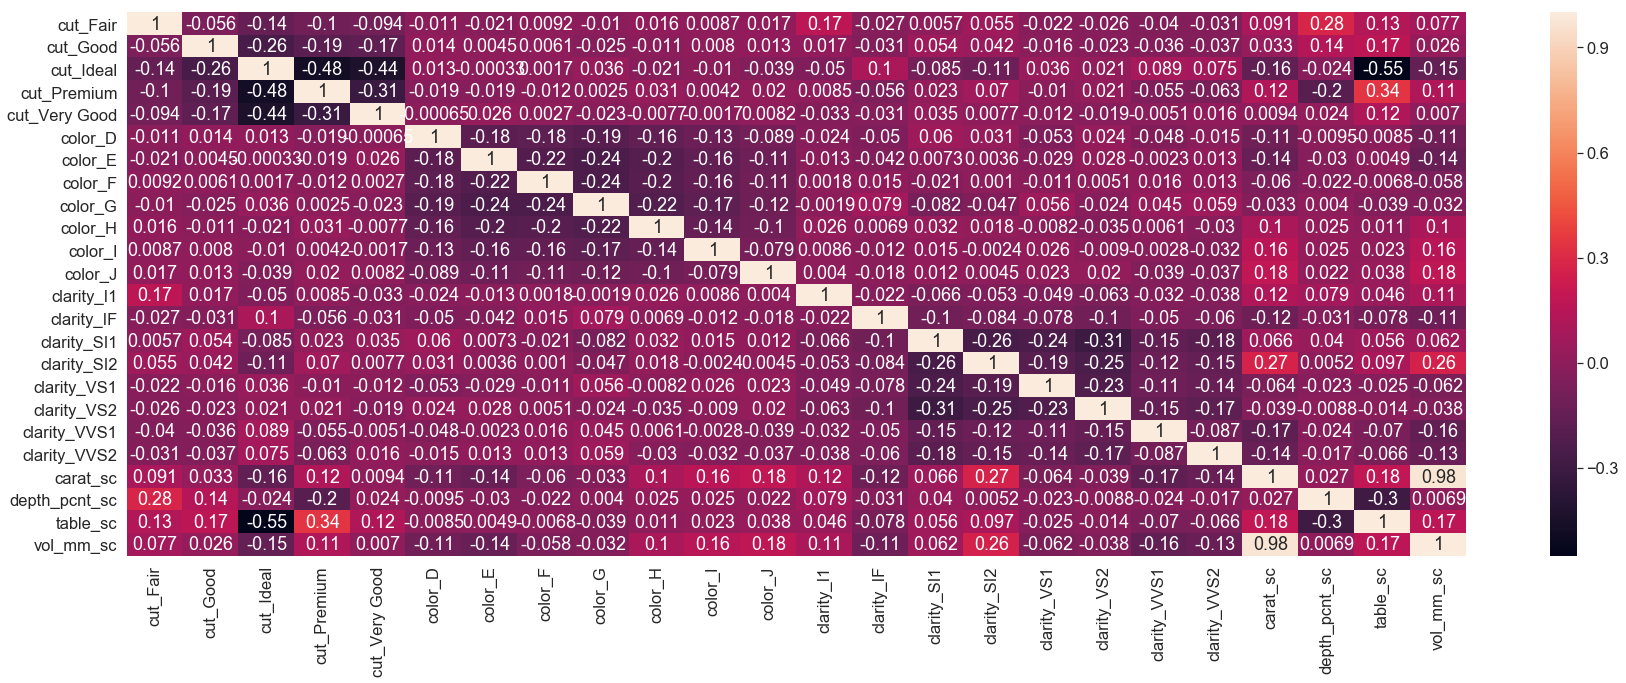

In [163]:
#Correlation between variables
plt.rcParams['figure.figsize'] = (30.0, 10.0)
X_train_corr = X_train.corr()
sns.heatmap(data=X_train_corr, annot=True)

#### Linear regression model using all features

In [191]:
#suffix _f1
lm = linear_model.LinearRegression()
model_f1 = lm.fit(X_train, y_train)
predictions_f1 = model_f1.predict(X_test)
coefficients_f1 = model_f1.coef_
mse_f1 = mean_squared_error(y_test, predictions_f1)
variance_score_f1 = r2_score(y_test, predictions_f1)
print('Coefficients:', coefficients_f1)
print('Mean Squared Error:', mse_f1)
print('RMSE:', np.sqrt(mse_f1))
print('Score:',variance_score_f1)

Coefficients: [  1.29789550e+14   1.29789550e+14   1.29789550e+14   1.29789550e+14
   1.29789550e+14   2.10738343e+13   2.10738343e+13   2.10738343e+13
   2.10738343e+13   2.10738343e+13   2.10738343e+13   2.10738343e+13
  -5.50812602e+14  -5.50812602e+14  -5.50812602e+14  -5.50812602e+14
  -5.50812602e+14  -5.50812602e+14  -5.50812602e+14  -5.50812602e+14
   4.15316406e+03  -2.76875000e+01  -5.49453125e+01   6.54687500e+01]
Mean Squared Error: 1376122.63668
RMSE: 1173.08253617
Score: 0.91334584534


#### Carat weight and volume are very closely related; in fact, they provide basically the same information since density is constant. Drop the volume measure and see what happens. Conclusion: What the volume feature adds is very small. The differences may be coincidental, may be due to measurement differences, or may interact with the categorical features differently.

In [172]:
#suffix _no_vol
X_train_no_vol = X_train.drop(columns = 'vol_mm_sc')
X_test_no_vol = X_test.drop(columns = 'vol_mm_sc')

In [173]:
model_no_vol = lm.fit(X_train_no_vol, y_train)
predictions_no_vol = model_no_vol.predict(X_test_no_vol)
coefficients_no_vol = model_no_vol.coef_
mse_no_vol = mean_squared_error(y_test, predictions_no_vol)
variance_score_no_vol = r2_score(y_test, predictions_no_vol)
print('Coefficients:', coefficients_no_vol)
print('Mean Squared Error:', mse_no_vol)
print('RMSE:', np.sqrt(mse_no_vol))
print('Score:',variance_score_no_vol)

Coefficients: [  1.29488048e+14   1.29488048e+14   1.29488048e+14   1.29488048e+14
   1.29488048e+14   1.48641251e+13   1.48641251e+13   1.48641251e+13
   1.48641251e+13   1.48641251e+13   1.48641251e+13   1.48641250e+13
  -5.49123795e+14  -5.49123795e+14  -5.49123795e+14  -5.49123795e+14
  -5.49123795e+14  -5.49123795e+14  -5.49123795e+14  -5.49123795e+14
   4.21730469e+03  -2.91250000e+01  -5.60937500e+01]
Mean Squared Error: 1376498.72523
RMSE: 1173.2428245
Score: 0.913322163123


#### Model with scaled carat weight only

In [157]:
#suffix _c_only
X_train_c_only = X_train[['carat_sc']]
X_test_c_only = X_test[['carat_sc']]

(43136, 1) (43136,)
(10784, 1) (10784,)


In [158]:
model_c_only = lm.fit(X_train_c_only, y_train)
predictions_c_only = model_c_only.predict(X_test_c_only)
coefficients_c_only = model_c_only.coef_
mse_c_only = mean_squared_error(y_test, predictions_c_only)
variance_score_c_only = r2_score(y_test, predictions_c_only)
print('Coefficients:', coefficients_c_only)
print('Mean Squared Error:', mse_c_only)
print('RMSE:', np.sqrt(mse_c_only))
print('Score:',variance_score_c_only)

Coefficients: [ 3676.79425715]
Mean Squared Error: 2443341.45518
RMSE: 1563.11914299
Score: 0.846143299514


#### Model with scaled carat weight, depth percentage and table only

In [169]:
#suffix _num_vals
X_train_num_vals = X_train[['carat_sc', 'depth_pcnt_sc', 'table_sc']]
X_test_num_vals = X_test[['carat_sc', 'depth_pcnt_sc', 'table_sc']]

In [170]:
model_num_vals = lm.fit(X_train_num_vals, y_train)
predictions_num_vals = model_num_vals.predict(X_test_num_vals)
coefficients_num_vals = model_num_vals.coef_
mse_num_vals = mean_squared_error(y_test, predictions_num_vals)
variance_score_num_vals = r2_score(y_test, predictions_num_vals)
print('Coefficients:', coefficients_num_vals)
print('Mean Squared Error:', mse_num_vals)
print('RMSE:', np.sqrt(mse_num_vals))
print('Score:',variance_score_num_vals)

Coefficients: [ 3725.91681721  -212.42171057  -238.65712475]
Mean Squared Error: 2376783.21812
RMSE: 1541.68194454
Score: 0.850334457782


Of the linear regression models, using all features works best (returns the highest R^2 score without apparent overfitting.

#### KNN with all features, 3 and 5 neighbors

Using 5 neighbors instead of 3 did not improve the score significantly. Using distance weight improves the RMSE by about $30.

In [189]:
knn = neighbors.KNeighborsRegressor(n_neighbors = 3, weights = 'distance')
knn.fit(X_train , y_train)
accuracies = cross_val_score(estimator = knn, X = X_train, y = y_train, cv = 8,verbose = 1)
y_pred = knn.predict(X_test)
print('')
print('Score : %.5f' % knn.score(X_test, y_test))
print(accuracies)

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)**0.5
r2 = r2_score(y_test, y_pred)

print('')
print('MSE    : %0.2f ' % mse)
print('RMSE   : %0.2f ' % rmse)
print('R2     : %0.4f ' % r2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    6.9s finished



Score : 0.95837
[ 0.95761389  0.96598125  0.95806695  0.9548471   0.95960761  0.96254376
  0.96279592  0.95612271]

MSE    : 661041.26 
RMSE   : 813.04 
R2     : 0.9584 


#### Conclusion

The KNN regression model with 3 neighbors performed better than the linear regression model. It predicted the price of a diamond with more accuracy and smaller mean error. I think the KNN regression model performs better with the Diamonds dataset because it minimizes the effect of the small number of stoned that are 3 to 4 in carat weight, which skews prices high. The KNN regression model also accounts for some smaller, brilliant stones with carat weights between 1 and 2 that have a higher price due to characteristics other than size.

Improvements I could make to this notebook:
 - Record all results in a table
 - Use a function to run models, inputting different feature sets, without coding each fit separately.
 - Experiment to determine which of the encoded categorical variables have an impact on price; are all the features needed?
 - Understand if Seaborn plot setting statements can be executed once (without producing a blank plot) rather than repeated. 